# IQNx4 Chapter 2: Train All Networks

# 2.1 Imports and Configurations

In [4]:
import numpy as np
import pandas as pd

# import scipy as sp; import scipy.stats as st
import torch
import torch.nn as nn

print(f"using torch version {torch.__version__}")
# use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp

print("matplotlib version= ", mp.__version__)

import matplotlib.pyplot as plt

# reset matplotlib stle/parameters
import matplotlib as mpl

# reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-deep")
mp.rcParams["agg.path.chunksize"] = 10000
font_legend = 15
font_axes = 15
# %matplotlib inline
import sys
import os
#or use joblib for caching on disk
from joblib import  Memory
# from IPython.display import Image, display
# from importlib import import_module
# import plotly
try:
    import optuna

    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print("optuna is only used for hyperparameter tuning, not critical!")
    pass
import argparse
import time

# import sympy as sy
# import ipywidgets as wid;


# try:
#     IQN_BASE = os.environ["IQN_BASE"]
#     print("BASE directoy properly set = ", IQN_BASE)
#     utils_dir = os.path.join(IQN_BASE, "utils/")
#     sys.path.append(utils_dir)
#     import utils

#     # usually its not recommended to import everything from a module, but we know
#     # whats in it so its fine
#     from utils import *

#     print("DATA directory also properly set, in %s" % os.environ["DATA_DIR"])
# except Exception:
#     # IQN_BASE=os.getcwd()
#     print(
#         """\nBASE directory not properly set. Read repo README.    If you need a function from utils, use the decorator below, or add utils to sys.path\n
#     You can also do 
#     os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
#     or
#     os.environ['IQN_BASE']=os.getcwd()"""
#     )
#     pass




# from IPython.core.magic import register_cell_magic


# @debug
# def get_model_params_simple():
#     dropout=0.2
#     n_layers = 2
#     n_hidden=32
#     starting_learning_rate=1e-3
#     print('n_iterations, n_layers, n_hidden, starting_learning_rate, dropout')
#     return n_iterations, n_layers, n_hidden, starting_learning_rate, dropout


# update fonts
FONTSIZE = 14
font = {"family": "serif", "weight": "normal", "size": FONTSIZE}
mp.rc("font", **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc("text", usetex=True)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
# sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:
#######


IQN_BASE = os.environ["IQN_BASE"]
print("BASE directoy properly set = ", IQN_BASE)
utils_dir = os.path.join(IQN_BASE, "utils/")
sys.path.append(utils_dir)
import utils

# usually its not recommended to import everything from a module, but we know
# whats in it so its fine
from utils import *


DATA_DIR = os.environ["DATA_DIR"]
print(f"using DATA_DIR={DATA_DIR}")

memory = Memory(DATA_DIR)
################################### SET DATA CONFIGURATIONS ###################################

y_label_dict = {
    "RecoDatapT": "$p(p_T)$" + " [ GeV" + "$^{-1} $" + "]",
    "RecoDataeta": "$p(\eta)$",
    "RecoDataphi": "$p(\phi)$",
    "RecoDatam": "$p(m)$" + " [ GeV" + "$^{-1} $" + "]",
}

loss_y_label_dict = {
    "RecoDatapT": "$p_T^{reco}$",
    "RecoDataeta": "$\eta^{reco}$",
    "RecoDataphi": "$\phi^{reco}$",
    "RecoDatam": "$m^{reco}$",
}

X = ["genDatapT", "genDataeta", "genDataphi", "genDatam", "tau"]

# set order of training:
# pT_first: pT->>m->eta->phi
# m_first: m->pT->eta->phi


ORDER = "m_First"

if ORDER == "m_First":
    FIELDS = {
        "RecoDatam": {
            "inputs": X,
            "xlabel": r"$m$ (GeV)",
            "ylabel": "$m^{reco}$",
            "xmin": 0,
            "xmax": 25,
        },
        "RecoDatapT": {
            "inputs": ["RecoDatam"] + X,
            "xlabel": r"$p_T$ (GeV)",
            "ylabel": "$p_T^{reco}$",
            "xmin": 20,
            "xmax": 80,
        },
        "RecoDataeta": {
            "inputs": ["RecoDatam", "RecoDatapT"] + X,
            "xlabel": r"$\eta$",
            "ylabel": "$\eta^{reco}$",
            "xmin": -5,
            "xmax": 5,
        },
        "RecoDataphi": {
            "inputs": ["RecoDatam", "RecoDatapT", "RecoDataeta"] + X,
            "xlabel": r"$\phi$",
            "ylabel": "$\phi^{reco}$",
            "xmin": -3.2,
            "xmax": 3.2,
        },
    }


# Load and explore raw (unscaled) dataframes


all_variable_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
]
all_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
    "tau",
]




using torch version 1.9.0
matplotlib version=  3.5.1
using (optional) optuna version 2.8.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using DATA_DIR=/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


# 2.2: Load Required Functions

In [63]:

class LR_Cooler:
    def __init__(self, starting_lr: float, total_iterations: int, iter_: int) -> float:
        self.starting_lr=starting_lr
        self.iter_=iter_
        self.total_iterations= total_iterations
    def exponential_decay(self):
        return self.starting_lr * (np.exp(-  self.iter_/1e5 ))
    def exponential_decay_2(self):
        decay_rate=1e-3
        return self.starting_lr * np.exp(- decay_rate* self.iter)
    
    def fractional_decay(self):
        final_time = 1
        return self.starting_lr/(self.iter + final_time) 

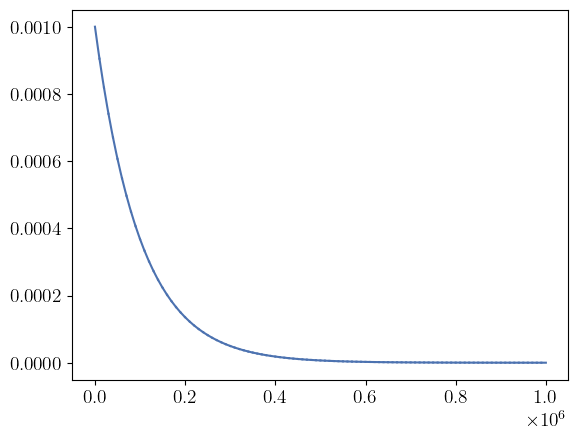

In [64]:
LR_sched = LR_Cooler(1e-3, np.arange(1e6), np.arange(1e6))
LR = LR_sched.exponential_decay()
plt.plot(np.arange(1e6), LR);plt.show()

In [116]:
################################### Load unscaled dataframes ###################################
################################### Load unscaled dataframes ###################################
@memory.cache
def load_raw_data():
    """Load raw train, test, and validation raw (unscaled) dataframes, in that order.

    Returns:
        list(pandas.DataFrame): train, test, valid raw datafranes
    """
    print(f'SUBSAMPLE = {SUBSAMPLE}')
    raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_valid_data=pd.read_csv(os.path.join(DATA_DIR,'validation_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )


    print('\n RAW TRAIN DATA SHAPE\n')
    print(raw_train_data.shape)
    print('\n RAW TRAIN DATA\n')
    raw_train_data.describe()#unscaled
    print('\n RAW TEST DATA\ SHAPEn')
    print(raw_test_data.shape)
    print('\n RAW TEST DATA\n')
    raw_test_data.describe()#unscaled

    return raw_train_data, raw_test_data, raw_valid_data


########## Generate scaled data###############
# scaled_train_data = L_scale_df(raw_train_data, title='scaled_train_data_10M_2.csv',
#                              save=True)
# print('\n\n')
# scaled_test_data = L_scale_df(raw_test_data,  title='scaled_test_data_10M_2.csv',
#                             save=True)
# print('\n\n')

# scaled_valid_data = L_scale_df(raw_valid_data,  title='scaled_valid_data_10M_2.csv',
#                             save=True)

# explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

################ Load scaled data##############
@utils.time_type_of_func(tuning_or_training='loading')
@memory.cache
def load_scaled_dataframes():
    """Load L-scaled train, test and validation according to Braden scaling, in that order.

    Returns:
        list(pandas.DataFarme): L-scaled train, test, validation dataframes, in that order.
    """
    # print("SCALED TRAIN DATA")
    scaled_train_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_train_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )

    # print("TRAINING FEATURES\n", scaled_train_data.head())

    scaled_test_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_test_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )

    scaled_valid_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_valid_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )
    return scaled_train_data, scaled_test_data, scaled_valid_data

# print('\nTESTING FEATURES\n', test_data_m.head())

# print('\ntrain set shape:',  train_data_m.shape)
# print('\ntest set shape:  ', test_data_m.shape)
# # print('validation set shape:', valid_data.shape)



def get_train_scale_dict(USE_BRADEN_SCALING):
    """Get a dictionary containing mean and standard deviation of each gen and reco feature. 

    Args:
        USE_BRADEN_SCALING (bool): Whether you wish to use the Braden scaling. If True, it uses the L-scaled train dataframe. If False, it uses the unscaled dataframe.

    Returns:
        dict: dictionary of floats containing mean and standard deviation of each gen and reco feature. 
    """
    if USE_BRADEN_SCALING==True:
        TRAIN_SCALE_DICT = get_scaling_info(scaled_train_data)
        print('BRADEN SCALING DICTIONARY')
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    else:
        print('NORMAL UNSCALED DICTIONARY')
        TRAIN_SCALE_DICT = get_scaling_info(raw_train_data)
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    return TRAIN_SCALE_DICT



################################ SPLIT###########
# Currently need the split function again here
# @memory.cache
def split_t_x(df, target, input_features):
    """Get the target as the ratio, according to the T equation.
    
    Returns:
    list(numpy.array): list of numpy array of target and training features"""

    if target == "RecoDatam":
        t = T("m", scaled_df=scaled_train_data)
    if target == "RecoDatapT":
        t = T("pT", scaled_df=scaled_train_data)
    if target == "RecoDataeta":
        t = T("eta", scaled_df=scaled_train_data)
    if target == "RecoDataphi":
        t = T("phi", scaled_df=scaled_train_data)
    x = np.array(df[input_features])
    return np.array(t), x

# @memory.cache
def normal_split_t_x(df, target, input_features):
    """splot dataframe into targets and feature arrays.

    Args:
        df (pandas.DataFrame): Dataframe of train, test or validation data.
        target (str): Choice of "RecoDatapT", "RecoDataeta", "RecoDataphi","RecoDatam" as target.
        input_features (list(str)): list of training features labels

    Returns:
    list(numpy.array): list of numpy array of target and training features
 """
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x




################ Apply Z scaling############
def z(x):
    """Simple z-score standardization. Used for targets"""
    eps = 1e-20
    return (x - np.mean(x)) / (np.std(x) + eps)
def z_inverse(xprime, x):
    return xprime * np.std(x) + np.mean(x)

# @memory.cache
def z2(x, mean, std):
    """
    The main z score function. Args:
        x (numpy.array): feature 1-D array
        mean (float): mean of the feature (in the training set)
        std (float): standard deviation of the feature (in the training set)

    Returns:
        numpy.array: z-score-scaled 1-D feature
    """
    eps = 1e-20
    scaled = (x - mean) / (std + eps)
    return np.array(scaled, dtype=np.float64)




# @memory.cache
def z_inverse2(xprime, train_mean, train_std):
    """
        The main z score de-scaling function. 
        
        Args:
        xprime (numpy.array): z-score-scaled feature 1-D array
        train_mean (float): mean of the feature (in the training set)
        train_std (float): standard deviation of the feature (in the training set)
        """
    return xprime * train_std + train_mean

# @memory.cache
def apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x):
    """TO ensure this z scaling is only applied once to the training features, we use a generator.
    This doesn't change the shapes of anything, just applies z to all the feature columns other than tau.
    
    Args:
    TRAIN_SCALE_DICT (dict(float)): dictionary of train set mean and standard deviation values
    train_x (numpy.array): 2-D numpy array of training features
    test_x (numpy.array):  2-D numpy array of test features
    valid_x (numpy.array):  2-D numpy array of validation features
    """
    for i in range(NFEATURES - 1):
        variable = list(TRAIN_SCALE_DICT)[i]
        train_mean = float(TRAIN_SCALE_DICT[variable]["mean"])
        train_std = float(TRAIN_SCALE_DICT[variable]["std"])
        train_x[:, i] = z2(train_x[:, i], mean=train_mean, std=train_std)
        test_x[:, i] = z2(test_x[:, i], mean=train_mean, std=train_std)
        valid_x[:, i] = z2(valid_x[:, i], mean=train_mean, std=train_std)
    yield train_x
    yield test_x
    yield valid_x


# @memory.cache
def apply_z_to_targets(train_t, test_t, valid_t):
    """apply z-score scaling to target columns

    Args:
        train_t (numpy.array): target column in the training set
        test_t (numpy.array): target column in the test set
        valid_t (numpy.array): target column in the validation set

    Yields:
        [type]: [description]
    """
    train_mean = np.mean(train_t)
    train_std = np.std(train_t)
    train_t_ = z2(train_t, mean=train_mean, std=train_std)
    test_t_ = z2(test_t, mean=train_mean, std=train_std)
    valid_t_ = z2(valid_t, mean=train_mean, std=train_std)

    yield train_t_
    yield test_t_
    yield valid_t_



# check that it looks correct
# fig = plt.figure(figsize=(10, 4))
# ax = fig.add_subplot(autoscale_on=True)
# ax.grid()
# for i in range(NFEATURES):
#     ax.hist(train_x[:,i], alpha=0.35, label=f'feature {i}' )
#     # set_axes(ax=ax, xlabel="Transformed features X' ",title="training features post-z score: X'=z(L(X))")
# ax.legend()
# plt.show()


######### Get beset hyperparameters
# tuned_dir = os.path.join(IQN_BASE,'best_params')
# tuned_filename=os.path.join(tuned_dir,'best_params_mass_%s_trials.csv' % str(int(n_trials)))
# BEST_PARAMS = pd.read_csv(os.path.join(IQN_BASE, 'best_params','best_params_Test_Trials.csv'))
# BEST_PARAMS=pd.read_csv(tuned_filename)
# print(BEST_PARAMS)



def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = utils.RegularizedRegressionModel(
        nfeatures=NFEATURES,
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout_1=PARAMS["dropout_1"],
        dropout_2=PARAMS["dropout_2"],
        activation=PARAMS["activation"],
    )
    # model.apply(initialize_weights)
    print(model)
    return model




class SaveModelCheckpoint:
    """Continuous model-checkpointing class. Updates the latest checkpoint of an object based o validation loss each time its called. 
    """
    def __init__(self, best_valid_loss=np.inf):
        """Initiate an instance of the class based on filename and best_valid_loss/

        Args:
            best_valid_loss (float, optional): Best possible validation loss of a checkpoint object. Defaults to np.inf.
        """
        self.best_valid_loss = best_valid_loss
        self.filename_model=filename_model

    def __call__(self, model, current_valid_loss, filename_model):
        """When an object of the calss is called, its validation loss gets updated and the model based 
        on the latest validation loss is saved.

        Args:
            model: utils.RegularizedRegressionModel object.
            current_valid_loss (float): current (latest) validation loss of this model during the training process.
            filename_model (str): filename in which the latest model will be saved. Can be a relative or local path. 
        """
        if current_valid_loss < self.best_valid_loss:
            # update the best loss
            self.best_valid_loss = current_valid_loss
            # filename_model='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
            # filename_model = "Trained_IQNx4_%s_TUNED_2lin_with_noise.dict" % target

            # note that n_iterations is the total n_iterations, we dont want to save a million files for each iteration
            trained_models_dir = "trained_models"
            mkdir(trained_models_dir)
            # on cluster, Im using another TRAIN directory
            PATH_model = os.path.join(
                IQN_BASE,
                "JupyterBook",
                "Cluster",
                "TRAIN",
                trained_models_dir,
                filename_model,
            )
            torch.save(model.state_dict(), PATH_model)
            print(
                f"\nCurrent valid loss: {current_valid_loss};  saved better model at {PATH_model}"
            )
            # save using .pth object which if a dictionary of dicionaries, so that I can have PARAMS saved in the same file


def train(
    target,
    model,
    avloss,
    getbatch,
    train_x,
    train_t,
    valid_x,
    valid_t,
    PARAMS,
    traces,
    step,
    window,
):
    """Training Function. 

    Args:
        target (str): hoice of "RecoDatapT", "RecoDataeta", "RecoDataphi","RecoDatam" as target.
        model a torch NN model, e.g utils.RegularizedRegressionModel.
        avloss (float): average training losss
        getbatch (function): a get_batch function
        train_x (numpy.DataFrame): 2-D numpy array of training features
        train_t (numpy.DataFrame:  1-D numpy array of training targets
        valid_x (numpy.DataFrame): 2-D numpy array of validation features
        valid_t (numpy.DataFrame: 1-D numpy array of validation targets
        PARAMS (dict): dictionary of model/training parameters 
        traces (tuple): tuple of  
        (iteration, training accuracy, validation accuracy, running average of validation accuracy) 
        = (xx, yy_t, yy_v, yy_v_avg) 
        step (int): number of iterations to take a printout step of the traces
        window (int): window of running average of validation loss  

    Returns:
        tuple: traces
    """
    
    # TODO: obviously, for reference, the "traces" should be saved as a 2D numpy array
    # with the same naming format as the "model_filename", so that it can be opened later and 
    # plot loss curves for different models.
    
    # TODO: decay the stepsize, such that steps (and hence checkpointing) are large in the beginnig to the learning
    # process (which corresponds to high learning rates), and decrease as time steps increase.
    batch_size = PARAMS['batch_size']
    n_iterations = PARAMS['n_iterations']
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    model_checkpoint = SaveModelCheckpoint()
    n = len(valid_x)
    
    print("Iteration vs average loss")
    print("%10s\t%10s\t%10s" % ("iteration", "train-set", "test-set"))
    
    fifth_n_iterations=int(n_iterations//5)
    starting_learning_rate = PARAMS['starting_learning_rate']
    for ii in range(n_iterations):
        #experiment with annealing LR from beginning
        # LR_sched=LR_Cooler(starting_lr=starting_learning_rate, total_iterations=n_iterations, iter_=ii)
        # learning_rate=LR_sched.exponential_decay()
#         # starting learning rate (first fifth)
        learning_rate= starting_learning_rate
        
#         #second fifth
#         if 2* fifth_n_iterations < ii < 3*fifth_n_iterations:
#             learning_rate=starting_learning_rate/10 #1e-2
            
#         #third fifth
#         if 3*fifth_n_iterations < ii < 4*fifth_n_iterations:
#             learning_rate=starting_learning_rate/100 #1e-3
#         #frouth fifth: stary decay LR
#         if ii > 4*fifth_n_iterations:
#             learning_rate = decay_LR(ii)
            
        
        # add weight decay (important regularization to reduce overfitting)
        L2 = 1
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2)
        #SGD allows for: momentum=0, dampening=0, weight_decay=0, nesterov=boolean, differentiable=boolean

        optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(),
        lr=learning_rate,
         # amsgrad=True, 

        #  weight_decay=L2,#
        # differentiable=True,
        #For SGD nesterov, it requires momentum and zero dampening
        # dampening=0,
        # momentum=momentum,
        # nesterov=True
        # BUT no one should ever use SGD in 2022! Adam converges much better and faster.
        )
        
        #if ii > 1e4: learning_rate=1e-4
        # set mode to training so that training specific
        # operations such as dropout are enabled.
        # time_p_start = time.perf_counter()
        model.train()

        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        # Take df/ dtau
        # x = torch.from_numpy(batch_x).float()
        # # print('x is leaf: ', x.is_leaf)
        # x.requires_grad_(True)
        # # x.retain_grad()
        # # print('x is leaf after retain: ', x.is_leaf)
        # # x.requires_grad_(True)
        # # x.retain_grad()
        # f = model(x)
        # f = f.view(-1)
        # #multiply the model by its ransverse, remember we can only take gradients of scalars
        # #and f will be a vector before this
        # f = f @ f.t()
        # f.retain_grad()
        # f.backward(gradient=torch.ones_like(f), retain_graph=True)
        # df_dx = x.grad
        # df_dtau = df_dx[:,-1]
        # x.grad.zero_()
        
        #add noise to training data
        # batch_x = add_noise(batch_x)
        # batch_t = add_noise(batch_t)
        
        # Try torch scheduler
        scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        scheduler.step()

        with torch.no_grad():  # no need to compute gradients
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()

        outputs = model(x).reshape(t.shape)

        empirical_risk = avloss(outputs, t, x)

        optimizer.zero_grad()  # clear previous gradients
        empirical_risk.backward()  # compute gradients

        optimizer.step()  # move one step towards the minimum of the loss function using an SGD-like algorithm.
        
        

        if ii % step == 0:

            print(f"\t\tCURRENT LEARNING RATE: {learning_rate}")
            acc_t = validate(model, avloss, train_x[:n], train_t[:n])
            #acc_t: list of training losses
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            #acc_v: list of validation losses
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            previous_iter_valid_loss = yy_v[-1]
            print(f'previous_iter_valid_loss : {previous_iter_valid_loss}\n')
            # save better models based on valid loss
            # filename_model="Trained_IQNx4_%s_TUNED_0lin_with_high_noise3.dict" % target
            filename_model=get_model_filename(target, PARAMS)
             
            model_checkpoint(model=model, filename_model =filename_model ,current_valid_loss=acc_v)
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if len_yy_v < window:
                yy_v_avg.append(yy_v[-1])
            elif len_yy_v == window:
                yy_v_avg.append(sum(yy_v) / window)
            else:
                acc_v_avg = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window - 1]
                yy_v_avg.append(acc_v_avg / window)

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)

                print(
                    "\r%10d\t%10.6f\t%10.6f\t%10.6f"
                    % (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]),
                    end="",
                )
        # time_p_end = time.perf_counter()
        # time_for_this_iter = time_p_end-time_p_start
        # time_per_example = time_for_this_iter/batch_size
        # print(f'training time for one example: {time_per_example}')

    print()
    return (xx, yy_t, yy_v, yy_v_avg)


@utils.time_type_of_func(tuning_or_training="training")
def run(
    target,
    model,
    train_x,
    train_t,
    valid_x,
    valid_t,
    traces,
    PARAMS,
    traces_step,
    traces_window,
    save_model,
):


    traces = train(
        target,
        model,
        average_quantile_loss,
        get_batch,
        train_x,
        train_t,
        valid_x,
        valid_t,
        PARAMS,
        traces,
        step=traces_step,
        window=traces_window,
    )

    if save_model:
        filename = "Trained_IQNx4_%s_%sK_iter.dict" % (
            target,
            str(int(n_iterations / 1000)),
        )
        PATH = os.path.join(IQN_BASE, "trained_models", filename)
        torch.save(model.state_dict(), PATH)
        print("\ntrained model dictionary saved in %s" % PATH)
    return model


def get_train_scale_dict(USE_BRADEN_SCALING):
    if USE_BRADEN_SCALING==True:
        TRAIN_SCALE_DICT = utils.get_scaling_info(scaled_train_data)
        print("BRADEN SCALING DICTIONARY")
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    else:
        print("NORMAL UNSCALED DICTIONARY")
        TRAIN_SCALE_DICT = utils.get_scaling_info(raw_train_data)
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    return TRAIN_SCALE_DICT


@utils.debug
def save_model(model, PATH):
    print(model)
    torch.save(model.state_dict(), PATH)
    print("\ntrained model dictionary saved in %s" % PATH)


@utils.debug
def save_model_params(model, PATH):
    print(model)
    torch.save(model.state_dict(), PATH)
    print("\ntrained model dictionary saved in %s" % PATH)


@utils.debug
def load_model(PATH):
    # n_layers = int(BEST_PARAMS["n_layers"])
    # hidden_size = int(BEST_PARAMS["hidden_size"])
    # dropout = float(BEST_PARAMS["dropout"])
    # optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    # learning_rate =  float(BEST_PARAMS["learning_rate"])
    # batch_size = int(BEST_PARAMS["batch_size"])
    model = utils.RegularizedRegressionModel(
        nfeatures=train_x.shape[1],
        ntargets=1,
        nlayers=n_layers,
        hidden_size=hidden_size,
        dropout=dropout,
    )
    model.load_state_dict(torch.load(PATH))
    # OR
    # model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
    model.eval()
    print(model)
    return model


def load_trained_model(PATH, PARAMS):
    model = utils.RegularizedRegressionModel(
        nfeatures=NFEATURES,
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout_1=PARAMS["dropout_1"],
        dropout_2=PARAMS["dropout_2"],
        activation=PARAMS["activation"],
    )
    model.load_state_dict(torch.load(PATH))
    print(model)
    model.train()
    return model

# 2.3 Load Data, split, scale, and Train Mass

In [117]:
#######################################
target = "RecoDatam"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)

print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING=False
#####################################
################################### CONFIGURATIONS ###################################

JUPYTER = True
use_subsample = False
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(1e5)  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None




########################################################################################
raw_train_data, raw_test_data, raw_valid_data =load_raw_data()
# Load scaled data
# scaled_train_data, scaled_test_data, scaled_valid_data = load_scaled_dataframes()


# Get targets and features
# if USE_BRADEN_SCALING==True:
#     print(f"spliting data for {target}")
#     train_t, train_x = split_t_x(
#         df=scaled_train_data, target=target, input_features=features
#     )
#     print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
#     print("\n Training features:\n")
#     print(train_x)
#     valid_t, valid_x = split_t_x(
#         df=scaled_valid_data, target=target, input_features=features
#     )
#     print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
#     test_t, test_x = split_t_x(df=scaled_test_data, target=target, input_features=features)
#     print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

# else:
#     print(f"spliting data for {target}")
#     train_t, train_x = normal_split_t_x(
#     df=raw_train_data, target=target, input_features=features
#     )
#     print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
#     print("\n Training features:\n")
#     print(train_x)
#     valid_t, valid_x = normal_split_t_x(
#     df=raw_valid_data, target=target, input_features=features
#     )
#     print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
#     test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
#     print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print(f"spliting data for {target}")
train_t, train_x = normal_split_t_x(
df=raw_train_data, target=target, input_features=features
)
print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
print("\n Training features:\n")
print(train_x)
valid_t, valid_x = normal_split_t_x(
df=raw_valid_data, target=target, input_features=features
)
print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
NFEATURES = train_x.shape[1]
######################################################

# Apply z scaling to features and targets
# to features
TRAIN_SCALE_DICT=get_train_scale_dict(USE_BRADEN_SCALING)
apply_z_generator = apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x)
train_x_z_scaled = next(apply_z_generator)
test_x_z_scaled = next(apply_z_generator)
valid_x_z_scaled = next(apply_z_generator)
print(valid_x_z_scaled.mean(axis=0), valid_x_z_scaled.std(axis=0))
print(train_x_z_scaled.mean(axis=0), train_x_z_scaled.std(axis=0))

# to targets
apply_z_to_targets_generator = apply_z_to_targets(
    train_t, test_t, valid_t
)
train_t_z_scaled = next(apply_z_to_targets_generator)
test_t_z_scaled = next(apply_z_to_targets_generator)
valid_t_z_scaled = next(apply_z_to_targets_generator)
print(valid_t_z_scaled.mean(), valid_t_z_scaled.std())
print(train_t_z_scaled.mean(), train_t_z_scaled.std())


Training Features:
 ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target =  RecoDatam
USING NEW DATASET

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-4125311998.load_raw_data...
load_raw_data()
SUBSAMPLE = None

 RAW TRAIN DATA SHAPE

(8000000, 9)

 RAW TRAIN DATA


 RAW TEST DATA\ SHAPEn
(1000000, 9)

 RAW TEST DATA

___________________________________________________load_raw_data - 12.8s, 0.2min
spliting data for RecoDatam
train_t shape =  (8000000,) train_x shape =  (8000000, 5)

 Training features:

[[29.4452      0.828187    2.90213     2.85348     0.36130954]
 [24.3193     -1.16351     0.636469    5.83685     0.12689925]
 [24.3193     -1.16351     0.636469    5.83685     0.96230681]
 ...
 [41.4192     -2.23358    -2.81921     7.19348     0.08421659]
 [35.4637     -1.12318     0.356494    6.06597     0.05535172]
 [26.5586     -1.09427    -1.49334     4.25409     0.07489863]]
valid_t shape 

Decide Whether to use Braden Scaling

# Define Mass Model Parameters

In [118]:
###########################################################
# Decide on parameters for this model and training
PARAMS_m = {
"n_layers": int(20),
"hidden_size": int(3),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'Adam',
    'starting_learning_rate':float(0.5),
    'momentum':float(0.6),
    'batch_size':int(512),
    'n_iterations': int(5e6),
}

## Train Mass

### The model that needs the longest time in training is mass. Click here to scroll down to train $p_T$.

In [119]:
optimizer_name=PARAMS_m['optimizer_name']
print(type(optimizer_name))
# optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
NITERATIONS=PARAMS_m['n_iterations']
BATCHSIZE=PARAMS_m['batch_size']
comment=''



# N_epochs X N_train_examples = N_iterations X batch_size
N_epochs = (NITERATIONS * BATCHSIZE) / int(train_x.shape[0])
print(f"training for {NITERATIONS} iteration, which is  {N_epochs} epochs")


filename_model = get_model_filename(target, PARAMS_m)
trained_models_dir = "trained_models"
mkdir(trained_models_dir)
# on cluster, Im using another TRAIN directory
PATH_model = os.path.join(
    IQN_BASE, #the loaction of the repo
    "JupyterBook", #up tp TRAIN could be combined in a srs dicretory
    "Cluster", 
    "TRAIN",
    trained_models_dir, #/trained_models 
    filename_model # utils.get_model_filename has the saved file format 
)

#LOAD EITHER TRAINED OR UNTRAINED MODEL
# to load untrained model (start training from scratch), uncomment the next line
untrained_model = load_untrained_model(PARAMS_m)
# to continune training of model (pickup where the previous training left off), uncomment below
# trained_model =load_trained_model(PATH=PATH_model, PARAMS=PARAMS_m)

IQN_trace = ([], [], [], [])
traces_step = int(20)
traces_window = traces_step
IQN = run(
    target=target,
    model=untrained_model,
    train_x=train_x_z_scaled,
    train_t=train_t_z_scaled,
    valid_x=test_x_z_scaled,
    valid_t=test_t_z_scaled,
    traces=IQN_trace,
    PARAMS=PARAMS_m,
    traces_step=traces_step,
    traces_window=traces_window,
    save_model=False,
)



SAVE_LAST_MODEL=False
if SAVE_LAST_MODEL:
    # ## Save last iteration of trained model 
    #dont save the last model, it might be worse than previous iterations, which were automatically savedby model checkpoints

    final_path = get_model_filename(target, PARAMS_m).split('.dict')[0]+'_FINAL.dict'

    trained_models_dir = "trained_models"
    mkdir(trained_models_dir)
    # on cluster, Im using another TRAIN directory
    PATH_final_model = os.path.join(
    IQN_BASE, "JupyterBook", "Cluster", "TRAIN", trained_models_dir, final_path
    )

    save_model(IQN, PATH_final_model)

<class 'str'>
training for 5000000 iteration, which is  320.0 epochs
RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.3)
    (5): Linear(in_features=3, out_features=3, bias=True)
    (6): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.3)
    (8): Linear(in_features=3, out_features=3, bias=True)
    (9): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.3)
    (11): Linear(in_features=3, out_features=3, bias=True)
    (12): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.3)
    (14): Linear(in_features=3, out_fea

/home/ali/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


previous_iter_valid_loss : 0.3664275109767914


Current valid loss: 0.3664275109767914;  saved better model at /home/ali/Desktop/Pulled_Github_Repositories/torchQN/JupyterBook/Cluster/TRAIN/trained_models/Trained_IQNx4_RecoDatam_20_layer3_hiddenLeakyReLU_activation512_batchsize5000_Kiteration.dict
         0	  0.366663	  0.366428
		CURRENT LEARNING RATE: 0.5
previous_iter_valid_loss : 0.318241149187088


Current valid loss: 0.318241149187088;  saved better model at /home/ali/Desktop/Pulled_Github_Repositories/torchQN/JupyterBook/Cluster/TRAIN/trained_models/Trained_IQNx4_RecoDatam_20_layer3_hiddenLeakyReLU_activation512_batchsize5000_Kiteration.dict
        20	  0.318823	  0.318241	  0.318241		CURRENT LEARNING RATE: 0.5
previous_iter_valid_loss : 0.3382752537727356

        40	  0.338497	  0.338275	  0.338275		CURRENT LEARNING RATE: 0.5
previous_iter_valid_loss : 0.4142429232597351

        60	  0.414315	  0.414243	  0.414243		CURRENT LEARNING RATE: 0.5
previous_iter_valid_loss : 0.403

KeyboardInterrupt: 

In [ ]:
#######################################
target = "RecoDatapT"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)

print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING=False
#####################################
################################### CONFIGURATIONS ###################################

JUPYTER = True
use_subsample = False
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None




########################################################################################
raw_train_data, raw_test_data, raw_valid_data =load_raw_data()
# Load scaled data
# scaled_train_data, scaled_test_data, scaled_valid_data = load_scaled_dataframes()


# Get targets and features
# if USE_BRADEN_SCALING==True:
#     print(f"spliting data for {target}")
#     train_t, train_x = split_t_x(
#         df=scaled_train_data, target=target, input_features=features
#     )
#     print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
#     print("\n Training features:\n")
#     print(train_x)
#     valid_t, valid_x = split_t_x(
#         df=scaled_valid_data, target=target, input_features=features
#     )
#     print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
#     test_t, test_x = split_t_x(df=scaled_test_data, target=target, input_features=features)
#     print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

# else:
#     print(f"spliting data for {target}")
#     train_t, train_x = normal_split_t_x(
#     df=raw_train_data, target=target, input_features=features
#     )
#     print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
#     print("\n Training features:\n")
#     print(train_x)
#     valid_t, valid_x = normal_split_t_x(
#     df=raw_valid_data, target=target, input_features=features
#     )
#     print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
#     test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
#     print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print(f"spliting data for {target}")
train_t, train_x = normal_split_t_x(
df=raw_train_data, target=target, input_features=features
)
print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
print("\n Training features:\n")
print(train_x)
valid_t, valid_x = normal_split_t_x(
df=raw_valid_data, target=target, input_features=features
)
print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
NFEATURES = train_x.shape[1]
######################################################

# Apply z scaling to features and targets
# to features
TRAIN_SCALE_DICT=get_train_scale_dict(USE_BRADEN_SCALING)
apply_z_generator = apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x)
train_x_z_scaled = next(apply_z_generator)
test_x_z_scaled = next(apply_z_generator)
valid_x_z_scaled = next(apply_z_generator)
print(valid_x_z_scaled.mean(axis=0), valid_x_z_scaled.std(axis=0))
print(train_x_z_scaled.mean(axis=0), train_x_z_scaled.std(axis=0))

# to targets
apply_z_to_targets_generator = apply_z_to_targets(
    train_t, test_t, valid_t
)
train_t_z_scaled = next(apply_z_to_targets_generator)
test_t_z_scaled = next(apply_z_to_targets_generator)
valid_t_z_scaled = next(apply_z_to_targets_generator)
print(valid_t_z_scaled.mean(), valid_t_z_scaled.std())
print(train_t_z_scaled.mean(), train_t_z_scaled.std())



###########################################################
# Decide on parameters for this model and training
PARAMS_pT = {
"n_layers": int(10),
"hidden_size": int(6),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'Adam',
    'starting_learning_rate':float(1e-4),
    'momentum':float(0.6),
    'batch_size':int(1024),
    'n_iterations': int(3e5),
}

optimizer_name=PARAMS_pT['optimizer_name']
print(type(optimizer_name))
# optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
NITERATIONS=PARAMS_pT['n_iterations']
BATCHSIZE=PARAMS_pT['batch_size']
comment=''



# N_epochs X N_train_examples = N_iterations X batch_size
N_epochs = (NITERATIONS * BATCHSIZE) / int(train_x.shape[0])
print(f"training for {NITERATIONS} iteration, which is  {N_epochs} epochs")

#train model from scratch
filename_model = utils.get_model_filename(target, PARAMS_pT)
#or pick up trained model
filename_model = 'Trained_IQNx4_RecoDatapT_10_layer6_hiddenLeakyReLU_activation512_batchsize300_Kiteration.dict'

trained_models_dir = "trained_models"
utils.mkdir(trained_models_dir)
# on cluster, Im using another TRAIN directory
PATH_model = os.path.join(
    IQN_BASE, #the loaction of the repo
    "JupyterBook", #up tp TRAIN could be combined in a srs dicretory
    "Cluster", 
    "TRAIN",
    trained_models_dir, #/trained_models 
    filename_model # utils.get_model_filename has the saved file format 
)

#LOAD EITHER TRAINED OR UNTRAINED MODEL
# to load untrained model (start training from scratch), uncomment the next line
untrained_model = load_untrained_model(PARAMS_pT)
# to continune training of model (pickup where the previous training left off), uncomment below
trained_model =load_trained_model(PATH=PATH_model, PARAMS=PARAMS_pT)

IQN_trace = ([], [], [], [])
traces_step = 20
traces_window = traces_step
IQN = run(
    target=target,
    model=trained_model,
    train_x=train_x_z_scaled,
    train_t=train_t_z_scaled,
    valid_x=test_x_z_scaled,
    valid_t=test_t_z_scaled,
    traces=IQN_trace,
    PARAMS=PARAMS_pT,
    traces_step=traces_step,
    traces_window=traces_window,
    save_model=False,
)



SAVE_LAST_MODEL=False
if SAVE_LAST_MODEL:
    # ## Save last iteration of trained model 
    #dont save the last model, it might be worse than previous iterations, which were automatically savedby model checkpoints

    final_path = utils.get_model_filename(target, PARAMS_pT).split('.dict')[0]+'_FINAL.dict'

    trained_models_dir = "trained_models"
    utils.mkdir(trained_models_dir)
    # on cluster, Im using another TRAIN directory
    PATH_final_model = os.path.join(
    IQN_BASE, "JupyterBook", "Cluster", "TRAIN", trained_models_dir, final_path
    )

    save_model(IQN, PATH_final_model)


In [ ]:
# to continune training of model (pickup where the previous training left off), uncomment below
trained_model =load_trained_model(PATH=PATH_model, PARAMS=PARAMS_pT)

IQN_trace = ([], [], [], [])
traces_step = 20
traces_window = traces_step
IQN = run(
    target=target,
    model=trained_model,
    train_x=train_x_z_scaled,
    train_t=train_t_z_scaled,
    valid_x=test_x_z_scaled,
    valid_t=test_t_z_scaled,
    traces=IQN_trace,
    PARAMS=PARAMS_pT,
    traces_step=traces_step,
    traces_window=traces_window,
    save_model=False,
)